# CS7643: GPT2 From Scratch & Fine Tuning

# 0. Setup

### [Optional] Set up Google Drive Connection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'cs7643/project'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['project notes.docx', 'Project Proposal.pdf', 'environment.yaml', 'README.md', 'instr_fine_tune', 'data', 'the-verdict.txt', 'model']


In [4]:
import sys
import numpy as np
import math
sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/cs7643/project']

In [6]:
# if running locally set GOOGLE PATH
import sys
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')

Running in google colab. Our path is `/content/drive/MyDrive/cs7643/project`


### Import Modules

In [7]:
!pip install tiktoken

In [8]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [9]:
import torch
print("torch version:", version("torch"))

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")

torch version: 2.6.0+cu124
Using device = cuda


In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
from torch import nn

In [12]:
import pandas as pd

In [13]:
import urllib
from pathlib import Path
import time
from tqdm import tqdm

# 1. Implement a GPT-2 Model

In [14]:
from model.gpt import GPTModel, text_to_token_ids, token_ids_to_text, generate_text_simple, generate, print_model_stats, TransformerBlock
from model.load_model import load_weights
from model.lora_gpt import LoRALayer, LinearWithLoRA, replace_linear_with_lora, replace_linear_with_lora_last_n

## 1.0 Utils

In [15]:
from transformers import GPT2Model

# Available Models Names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

def get_raw_gpt(model_name):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    return GPTModel(base_config_copy)

def get_pretrained_gpt_model(model_name, verbose=True):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    gpt_model = GPTModel(base_config_copy)

    hf_pretrained_gpt = GPT2Model.from_pretrained(model_names[model_name], cache_dir="checkpoints")
    load_weights(gpt_model, hf_pretrained_gpt, base_config_copy)

    if verbose:
        print_model_stats(gpt_model, model_name)

    return gpt_model

In [16]:
def convert_to_lora_model(model: GPTModel, rank: int, alpha: int, last_n_trf_blocks=None) -> GPTModel:
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters before: {total_params:,}")

    for param in model.parameters():
        param.requires_grad = False

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters after: {total_params:,}")

    if last_n_trf_blocks is not None:
        replace_linear_with_lora_last_n(model, n=last_n_trf_blocks, rank=rank, alpha=alpha)
    else:
        replace_linear_with_lora(model, rank=rank, alpha=alpha)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable LoRA parameters: {total_params:,}")
    model.to(device)
    return model

## 1.1 Sanity Check Creating GPT Model

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

torch.manual_seed(123)
test_raw_gpt = GPTModel(GPT_CONFIG_124M)
test_raw_gpt.eval()  # disable dropout

start_context = "Hello, I am"

tokenizer = tiktoken.get_encoding("gpt2")
encoded_tensor = text_to_token_ids(start_context, tokenizer)

print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
print("\nInput text:", start_context)
print("Encoded input text:", encoded_tensor)
print("encoded_tensor.shape:", encoded_tensor.shape)

out_token_ids = generate_text_simple(
    model=test_raw_gpt,
    token_ids=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
decoded_text = token_ids_to_text(out_token_ids, tokenizer)

print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
print("\nOutput:", out_token_ids)
print("Output length:", len(out_token_ids[0]))
print("Output text:", decoded_text)


                      IN

Input text: Hello, I am
Encoded input text: tensor([[15496,    11,   314,   716]])
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Output length: 14
Output text: Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous


In [ ]:
total_params = sum(p.numel() for p in test_raw_gpt.parameters())
print(f"Total Parameters: {total_params:,}")

total_params_gpt2 =  total_params - sum(p.numel() for p in test_raw_gpt.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Total Parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160


In [ ]:
print_model_stats(test_raw_gpt, "GPT-124M")

Model Name: GPT-124M
	Total Parameters: 163,009,536
	Total Memory Requirement: 621.83 MB


## 1.2 Sanity Check Loading Pre-trained Weights

In [ ]:
# CHOOSE_MODEL = "gpt2-medium (355M)"
CHOOSE_MODEL = "gpt2-large (774M)"
test_pretrained_gpt = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

In [ ]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=test_pretrained_gpt.to(device),
    # token_ids=text_to_token_ids("Every effort moves", tokenizer).to(device),
    token_ids=text_to_token_ids("The state capital of New Jersey is Newark. The state capital of California is", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 The state capital of New Jersey is Newark. The state capital of California is Los Angeles. The state capital of New York is Albany. The state capital of Texas is Austin. The state capital of Florida is Miami. The state


## 1.3 Sanity check LoRA model

In [17]:
test_lora_gpt = get_pretrained_gpt_model("gpt2-small (124M)", verbose=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [18]:
total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in test_lora_gpt.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 163,037,184
Total trainable parameters after: 0


In [19]:
# replace_linear_with_lora(test_lora_gpt, rank=16, alpha=16)
replace_linear_with_lora_last_n(test_lora_gpt, n=2, rank=16, alpha=16)

total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Applying LoRA with rank=16, alpha=16 to the last 2 transformer blocks (indices 10 to 11).
Total trainable LoRA parameters: 1,258,768


In [20]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=test_lora_gpt.to(device),
    token_ids=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


# 3. The Verdict Dataset Loaders

In [ ]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

### Test on simple "The Verdict" data

In [ ]:
verdict_file_path = GOOGLE_DRIVE_PATH + '/the-verdict.txt'
# verdict_file_path = 'the-verdict.txt'       # If loaded directly to Google Colab Runtime

with open(verdict_file_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [ ]:
raw_text

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

# 4. Training Loop

In [38]:
from instr_fine_tune.train import calc_batch_loss, calc_loader_loss, evaluate_model, generate_and_print_sample, TrainingConfig, TrainingResults, train_model_simple, train_model
from instr_fine_tune.train_plots import plot_losses, plot_perplexity, plot_and_save_learning_rate

In [39]:
def save_training_results(results: TrainingResults, filename: str):
    results_dict = {
        "train_losses": results.train_losses,
        "val_losses": results.val_losses,
        "track_tokens_seen": results.track_tokens_seen,
        "train_perplexity": results.train_perplexity,
        "val_perplexity": results.val_perplexity
    }
    if results.track_lrs is not None:
        results_dict["track_lrs"] = results.track_lrs

    with open(filename, "w") as f:
        json.dump(results_dict, f)
        print(f"Training results saved to {filename}")

## 4.2 Simple Train loop

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [ ]:
with open(verdict_file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [ ]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


### 4.2.1 Sanity check the simple training loop

In [ ]:
torch.manual_seed(123)
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

sanity_check_training_results = train_model_simple(training_config)

NameError: name 'train_loader' is not defined

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(sanity_check_training_results.train_losses))
plot_losses(epochs_tensor,
            sanity_check_training_results.track_tokens_seen,
            sanity_check_training_results.train_losses,
            sanity_check_training_results.val_losses)

## 4.3 Advanced Train Loop

This training loop adds the following to the simple one:

1) Learning rate warmup

2) Cosine decay (after pear l.r has been reached)

3) Gradient clipping

### 4.3.1 Sanity check the advanced training loop

Typically, the number of warmup steps is between 0.1% to 20% of the total number of steps

In [ ]:
num_epochs = 15
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

27


In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

num_epochs = 15
training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=1,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
)

sanity_check_advanced_training_results = train_model(training_config)

Ep 1 (Iter 000000): Train loss 10.970, Val loss 10.938
Ep 1 (Iter 000005): Train loss 9.336, Val loss 9.460
	 Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.820, Val loss 8.186
Ep 2 (Iter 000015): Train loss 6.344, Val loss 6.892
	 Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.076, Val loss 6.595
Ep 3 (Iter 000025): Train loss 5.681, Val loss 6.771
	 Every effort moves you, the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the
Ep 4 (Iter 000030): Train loss 5.816, Val loss 6.818
Ep 4 (Iter 000035): Train loss 5.776, Val loss 6.863
	 Every effort moves youisisis.                                              
Ep 5 (Iter 000040): Train loss 5.438, Val loss 6.675
	 Every effort moves you.                                                 
Ep 6 (Iter 000045): 

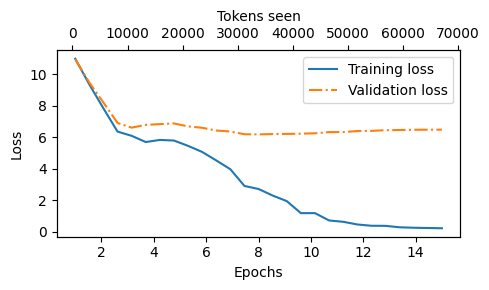

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs_tensor = torch.linspace(1, num_epochs, len(sanity_check_advanced_training_results.train_losses))

plot_losses(epochs_tensor,
            sanity_check_advanced_training_results.track_tokens_seen,
            sanity_check_advanced_training_results.train_losses,
            sanity_check_advanced_training_results.val_losses)
plt.tight_layout(); plt.savefig("3.pdf")
plt.show()

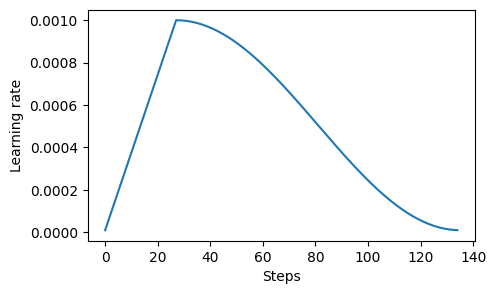

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(sanity_check_advanced_training_results.track_lrs)), sanity_check_advanced_training_results.track_lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.grid()
plt.show()

# 5. Mini-Alpaca Instruction Fine Tuning

## 5.0 Utils

In [17]:
def print_model_losses(model, train_loader, val_loader, device):
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)
    print("Training perplexity:", torch.exp(torch.tensor(train_loss)).item())
    print("Validation perplexity:", torch.exp(torch.tensor(val_loss)).item())

In [18]:
import json

def download_and_load_json_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

In [19]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

def format_response(entry):
    return f"\n\n### Response:\n{entry['output']}"

In [20]:
def load_json_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

In [21]:
def generate_model_response(model, test_data, file_path=None):
    model.eval()
    with torch.no_grad():
        for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
            instruction_text = format_input(entry)
            token_ids = generate(
                model=model.to(device),
                token_ids=text_to_token_ids(instruction_text, tokenizer).to(device),
                max_new_tokens=512,
                context_size=BASE_CONFIG["context_length"],
                eos_id=50256,
            )
            generated_text = token_ids_to_text(token_ids, tokenizer)

            response_text = generated_text[len(instruction_text):].replace("### Response:", "").strip()
            entry["generated_text"] = response_text

    # Save the data
    if file_path:
        with open(file_path, 'w') as f:
            json.dump(test_data, f, indent=4)

    return test_data

In [22]:
def print_model_losses(model, train_loader, val_loader, device):
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)
    print("Training perplexity:", torch.exp(torch.tensor(train_loss)).item())
    print("Validation perplexity:", torch.exp(torch.tensor(val_loss)).item())
    print()

## 5.2 Organizing data into training batches

In [23]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = format_response(entry)
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [24]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:          # item is just list of token ids e.g. [0, 1, 2, 3]
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [25]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

## 5.1 Prepare Dataset

In [ ]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_json_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [ ]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [ ]:
def save_first_n_entries(data, n, filename):
    """Saves the first n entries of the data to a JSON file."""
    try:
        with open(filename, 'w') as f:
            json.dump(data[:n], f, indent=4)  # Use indent for pretty printing
        print(f"Successfully saved the first {n} entries to {filename}")
    except Exception as e:
        print(f"An error occurred: {e}")

save_first_n_entries(
    data, 30,
    GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_sample_generation_data_30.json")

Successfully saved the first 30 entries to /content/drive/MyDrive/cs7643/project/instr_fine_tune/data/alpaca_sample_generation_data_30.json


In [ ]:
print(format_input(data[50]) + format_response(data[50]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 5.3 Creating data loaders for an instruction dataset

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
print("Train loader:")
i = 0
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    if i == 3: break
    i += 1

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])


## 5.4 Loading a pretrained LLM

In [ ]:
CHOOSE_MODEL = "gpt2-medium (355M)"
gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB


In [ ]:
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=gpt_m.to(device),
    token_ids=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print("Output text:\n", generated_text)

Output text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [ ]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## 5.5 Finetuning the LLM on instruction data

Initial Loss

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, gpt_m, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, gpt_m, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)
print("Training perplexity:", torch.exp(torch.tensor(train_loss)).item())
print("Validation perplexity:", torch.exp(torch.tensor(val_loss)).item())

Training loss: 3.825909471511841
Validation loss: 3.761934232711792
Training perplexity: 45.8745002746582
Validation perplexity: 43.03158187866211


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt_m.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

ift_mini_alpaca_training_config = TrainingConfig(
    model=gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,
)

ift_mini_alpaca_training_results = train_model_simple(ift_mini_alpaca_training_config)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

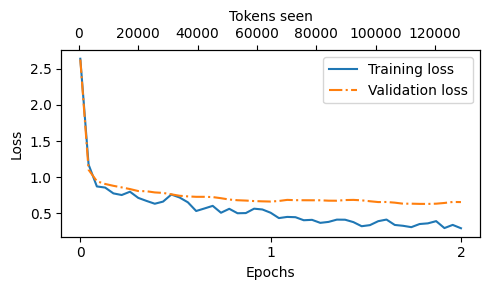

In [ ]:
epochs_tensor = torch.linspace(
    0, num_epochs, len(ift_mini_alpaca_training_results.train_losses))

plot_losses(epochs_tensor,
            ift_mini_alpaca_training_results.track_tokens_seen,
            ift_mini_alpaca_training_results.train_losses,
            ift_mini_alpaca_training_results.val_losses)

In [ ]:
token_ids = generate(
    model=gpt_m.to(device),
    token_ids=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print("Output text:\n", generated_text)

Output text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


# 6. Alpaca Instruction Fine Tuning

## 6.0 [Optional] Download the ALpaca Dataset

In [ ]:
alpaca_data_url = "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json"
file_path = GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_data.json"

In [ ]:
alpaca_data = download_and_load_json_file(file_path, alpaca_data_url)
print("Number of entries:", len(alpaca_data))

Number of entries: 52002


We will select only 12K entries of the 52K for compute reasons.

We will only keep entires whose output is less than 512 characters in length

In [ ]:
def filter_alpaca_data_by_len(alpaca_data, target_size=12000, max_output_len=512, filepath=None):
    filtered_alpaca_data = []

    for entry in alpaca_data:
            if len(entry['output']) < max_output_len:
                filtered_alpaca_data.append(entry)
            if len(filtered_alpaca_data) >= target_size:
                break

    if filepath:
        with open(filepath, 'w') as f:
            json.dump(filtered_alpaca_data, f, indent=4)

    return filtered_alpaca_data

In [ ]:
alpaca_data_15k = filter_alpaca_data_by_len(
    alpaca_data, target_size=15000, max_output_len=512,
    filepath=GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_data_15k.json")

In [ ]:
print("Number of entries:", len(alpaca_data_15k))

Number of entries: 15000


## Gemini Eval

In [26]:
from google import genai
from google.genai import types
from google.colab import userdata


def gemini_generate(prompt):
    client = genai.Client(
        api_key=userdata.get('GOOGLE_API_KEY')
    )

    # model = "gemini-2.5-pro-exp-03-25"
    model = "gemini-2.0-flash-thinking-exp-01-21"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        response_mime_type="text/plain",
    )

    for tries in range(3):
        try:
            response = client.models.generate_content(
                model=model,
                contents=contents,
                config=generate_content_config,
            )
            return response.text
        except Exception as e:
            print(f"An error occurred: {e}")
            time.sleep(30)
            continue

In [27]:
gemini_generate("Hello, how are you?")

'Hello! I am doing well, thank you for asking.  How are you today? Is there anything I can help you with? 😊'

In [28]:
def generate_model_scores(json_data, filepath=None):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['generated_text']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = gemini_generate(prompt)
        try:
            scores.append(int(score))
            print(f"Score: {score}")
            entry["score"] = score
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
        except Exception as e:
            print(f"An error occurred: {e}")
            time.sleep(5)
            continue

    if filepath:
        with open(filepath, 'w') as f:
            json.dump(json_data, f, indent=4)

    print(f"Mean score: {np.mean(scores)}")

    return scores

## 6.1 Prepare the Dataset

In [29]:
alpaca_data_15k_filepath = GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_data_15k.json"
alpaca_data_15k = load_json_data(alpaca_data_15k_filepath)

In [30]:
alpaca_sample_generation_data_filepath = GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_sample_generation_data_30.json"
alpaca_sample_generation_data = load_json_data(alpaca_sample_generation_data_filepath)

In [31]:
num_entries = len(alpaca_data_15k)
print("Number of entries:", num_entries)

Number of entries: 15000


In [32]:
train_portion = int(num_entries * 0.80)  # 85% for training
test_portion = int(num_entries * 0.10)    # 10% for testing
val_portion = num_entries - train_portion - test_portion  # Remaining 10% for validation

alpaca_train_data = alpaca_data_15k[:train_portion]
alpaca_test_data = alpaca_data_15k[train_portion:train_portion + test_portion]
alpaca_val_data = alpaca_data_15k[train_portion + test_portion:]

print("Training set length:", len(alpaca_train_data))
print("Validation set length:", len(alpaca_val_data))
print("Test set length:", len(alpaca_test_data))

Training set length: 12000
Validation set length: 1500
Test set length: 1500


In [33]:
subset_alpaca_test_data = alpaca_sample_generation_data + alpaca_test_data[:20]
print("Subset of test data length:", len(subset_alpaca_test_data))

Subset of test data length: 50


## 6.2 Create data loaders

In [34]:
num_workers = 0
batch_size = 4

torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")

alpaca_train_dataset = InstructionDataset(alpaca_train_data, tokenizer)
alpaca_train_loader = DataLoader(
    alpaca_train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

alpaca_val_dataset = InstructionDataset(alpaca_val_data, tokenizer)
alpaca_val_loader = DataLoader(
    alpaca_val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

alpaca_test_dataset = InstructionDataset(alpaca_test_data, tokenizer)
alpaca_test_loader = DataLoader(
    alpaca_test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [35]:
print("Train loader:")
i = 0
for inputs, targets in alpaca_train_loader:
    if i <= 3:
        print(inputs.shape, targets.shape)
    i += 1
print(f"There are {i} batches in the train loader")

Train loader:
torch.Size([4, 124]) torch.Size([4, 124])
torch.Size([4, 99]) torch.Size([4, 99])
torch.Size([4, 147]) torch.Size([4, 147])
torch.Size([4, 172]) torch.Size([4, 172])
There are 3000 batches in the train loader


## 6.3 Load Pretrained GPT2

In [ ]:
CHOOSE_MODEL = "gpt2-xl (1558M)"
# gpt2-large (774M)
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)

Model Name: gpt2-xl (1558M)
	Total Parameters: 1,638,022,400
	Total Memory Requirement: 6248.56 MB


In [ ]:
generated_data_file_path = GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/runs/pretrained_gpt_xl_generated_data.json"
generated_data = generate_model_response(
    model=pretrained_gpt_m,
    test_data=subset_alpaca_test_data,
    file_path=generated_data_file_path
)
generated_data_scores = generate_model_scores(generated_data, generated_data_file_path)

Scoring entries:   2%|▏         | 1/50 [00:01<01:28,  1.81s/it]

Score: 100


Scoring entries:   4%|▍         | 2/50 [00:04<02:04,  2.60s/it]

Score: 0


Scoring entries:   6%|▌         | 3/50 [00:08<02:19,  2.96s/it]

Score: 0


Scoring entries:   8%|▊         | 4/50 [00:16<03:48,  4.97s/it]

Score: 95


Scoring entries:  10%|█         | 5/50 [00:22<04:01,  5.37s/it]

Score: 5


Scoring entries:  12%|█▏        | 6/50 [00:25<03:20,  4.56s/it]

Score: 100


Scoring entries:  14%|█▍        | 7/50 [00:28<02:47,  3.90s/it]

Score: 0


Scoring entries:  16%|█▌        | 8/50 [00:29<02:14,  3.19s/it]

Score: 0


Scoring entries:  18%|█▊        | 9/50 [00:31<01:53,  2.76s/it]

Score: 0


Scoring entries:  20%|██        | 10/50 [00:33<01:40,  2.52s/it]

Score: 0


Scoring entries:  22%|██▏       | 11/50 [00:35<01:29,  2.29s/it]

Score: 0
An error occurred: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash-exp'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '21s'}]}}


Scoring entries:  24%|██▍       | 12/50 [01:09<07:34, 11.96s/it]

Score: 0


Scoring entries:  26%|██▌       | 13/50 [01:14<06:00,  9.76s/it]

Score: 0


Scoring entries:  28%|██▊       | 14/50 [01:17<04:42,  7.84s/it]

Score: 100


Scoring entries:  30%|███       | 15/50 [01:20<03:45,  6.46s/it]

Score: 0


Scoring entries:  32%|███▏      | 16/50 [01:28<03:51,  6.81s/it]

Score: 0


Scoring entries:  34%|███▍      | 17/50 [01:40<04:33,  8.28s/it]

Score: 100


Scoring entries:  36%|███▌      | 18/50 [01:47<04:15,  7.98s/it]

Score: 1


Scoring entries:  38%|███▊      | 19/50 [01:49<03:16,  6.33s/it]

Score: 0


Scoring entries:  40%|████      | 20/50 [01:52<02:34,  5.14s/it]

Score: 0


Scoring entries:  42%|████▏     | 21/50 [01:55<02:16,  4.72s/it]

Score: 100
An error occurred: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.0-flash-exp', 'location': 'global'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '0s'}]}}


Scoring entries:  44%|████▍     | 22/50 [02:28<06:03, 12.97s/it]

Score: 0


Scoring entries:  46%|████▌     | 23/50 [02:30<04:21,  9.68s/it]

Score: 0


Scoring entries:  48%|████▊     | 24/50 [02:32<03:12,  7.41s/it]

Score: 0


Scoring entries:  50%|█████     | 25/50 [02:34<02:25,  5.84s/it]

Score: 0


Scoring entries:  52%|█████▏    | 26/50 [02:37<02:01,  5.04s/it]

Score: 0


Scoring entries:  54%|█████▍    | 27/50 [02:42<01:54,  4.97s/it]

Score: 0


Scoring entries:  56%|█████▌    | 28/50 [02:48<01:58,  5.41s/it]

Score: 0


Scoring entries:  58%|█████▊    | 29/50 [02:50<01:31,  4.37s/it]

Score: 100


Scoring entries:  60%|██████    | 30/50 [02:52<01:14,  3.72s/it]

Score: 0


Scoring entries:  62%|██████▏   | 31/50 [02:55<01:02,  3.31s/it]

Score: 0


Scoring entries:  64%|██████▍   | 32/50 [02:56<00:50,  2.81s/it]

Score: 0
An error occurred: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.0-flash-exp', 'location': 'global'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '59s'}]}}


Scoring entries:  66%|██████▌   | 33/50 [03:32<03:35, 12.66s/it]

Score: 0


Scoring entries:  68%|██████▊   | 34/50 [03:37<02:47, 10.48s/it]

Score: 25


Scoring entries:  70%|███████   | 35/50 [03:40<02:01,  8.12s/it]

Score: 0


Scoring entries:  72%|███████▏  | 36/50 [03:43<01:31,  6.57s/it]

Score: 0


Scoring entries:  74%|███████▍  | 37/50 [03:45<01:08,  5.26s/it]

Score: 0


Scoring entries:  76%|███████▌  | 38/50 [03:55<01:20,  6.70s/it]

Score: 0


Scoring entries:  78%|███████▊  | 39/50 [03:57<00:58,  5.33s/it]

Score: 0


Scoring entries:  80%|████████  | 40/50 [04:01<00:48,  4.82s/it]

Score: 0


Scoring entries:  82%|████████▏ | 41/50 [04:03<00:35,  3.98s/it]

Score: 100


Scoring entries:  84%|████████▍ | 42/50 [04:06<00:29,  3.66s/it]

Score: 0


Scoring entries:  86%|████████▌ | 43/50 [04:11<00:27,  3.98s/it]

Score: 0


Scoring entries:  88%|████████▊ | 44/50 [04:14<00:23,  3.86s/it]

Score: 100


Scoring entries:  90%|█████████ | 45/50 [04:20<00:21,  4.32s/it]

Score: 3


Scoring entries:  92%|█████████▏| 46/50 [04:24<00:17,  4.27s/it]

Score: 0


Scoring entries:  94%|█████████▍| 47/50 [04:26<00:10,  3.54s/it]

Score: 0


Scoring entries:  96%|█████████▌| 48/50 [04:32<00:08,  4.45s/it]

Score: 0


Scoring entries:  98%|█████████▊| 49/50 [04:36<00:04,  4.37s/it]

Score: 0


Scoring entries: 100%|██████████| 50/50 [04:38<00:00,  5.58s/it]

Score: 0
Mean score: 18.58


In [ ]:
sample_text = format_input(alpaca_val_data[7])
print(sample_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite this statement into a declarative sentence:

### Input:
Do you plan to help others?


In [ ]:
torch.manual_seed(123)

token_ids = generate_text_simple(
    model=pretrained_gpt_m.to(device),
    token_ids=text_to_token_ids(sample_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print("Output text:\n", generated_text)

Output text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite this statement into a declarative sentence:

### Input:
Do you plan to help others?

### Output:

Yes

### Instruction:

Write a response that appropriately completes the request.

### Input:

Do you plan to


In [ ]:
response_text = (
    generated_text[len(sample_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

### Output:

Yes

### Instruction:

Write a response that appropriately completes the request.

### Input:

Do you plan to


## 6.4 Finetune on Alpaca 12k

In [40]:
def finetune_model(run_name):
    # 1) Initialize a Pre-trained GPT model
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=22)
    print_model_losses(pretrained_gpt_m, alpaca_train_loader, alpaca_val_loader, device)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(alpaca_train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    ift_alpaca_training_config = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=alpaca_train_loader,
        val_loader=alpaca_val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        start_context=format_input(alpaca_val_data[7]),
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
        run_name=run_name,
    )
    # ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
    ift_alpaca_training_results = train_model(ift_alpaca_training_config)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    # 3) Saving and logging
    directory_path = f"{GOOGLE_DRIVE_PATH}/instr_fine_tune/data/runs/{run_name}/"
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 3a) Save GPT model
    # model_file_path = directory_path + "pretrained_gpt_m.pth"
    # torch.save(pretrained_gpt_m.state_dict(), model_file_path)

    # 3b) Save training results
    training_results_file_path = directory_path + "training_results.json"
    save_training_results(ift_alpaca_training_results, training_results_file_path)

    # 3c) Plot learning curves
    plot_losses(ift_alpaca_training_config, ift_alpaca_training_results, directory_path + "loss_curves.png")
    plot_perplexity(ift_alpaca_training_config, ift_alpaca_training_results, directory_path + "perplexity_curves.png")

    # 3d) Generate sample responses
    generated_data_file_path = directory_path + "generated_data.json"
    generated_data = generate_model_response(
        model=pretrained_gpt_m,
        test_data=subset_alpaca_test_data,
        file_path=generated_data_file_path
    )

    return generated_data, ift_alpaca_training_results, ift_alpaca_training_config

In [ ]:
run_name = "run33"
generated_data, ift_alpaca_training_results, ift_alpaca_training_config = finetune_model(run_name)

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 406,286,336
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 22 transformer blocks (indices 2 to 23).
Total trainable LoRA parameters: 7,308,560
Training loss: 3.3896185874938967
Validation loss: 3.316080331802368
Training perplexity: 29.654640197753906
Validation perplexity: 27.552143096923828

Ep 1 (Iter 000000): Train loss 2.812, Val loss 2.985, Train perplexity 16.648, Val perplexity 19.777, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 1.566, Val loss 1.705, Train perplexity 4.787, Val perplexity 5.499, LR 1.083e-05
Ep 1 (Iter 000050): Train loss 1.392, Val loss 1.596, Train perplexity 4.021, Val perplexity 4.933, LR 1.167e-05
Ep 1 (Iter 000075): Train loss 1.385, Val loss 1.548, Train perplexity 3.996, Val perplexity 4.704, LR 1.250e-05


In [ ]:
directory_path = f"{GOOGLE_DRIVE_PATH}/instr_fine_tune/data/runs/{run_name}/"
generated_data_file_path = directory_path + "generated_data.json"
generated_data_file_path

In [ ]:
generated_data_scores = generate_model_scores(generated_data, generated_data_file_path)

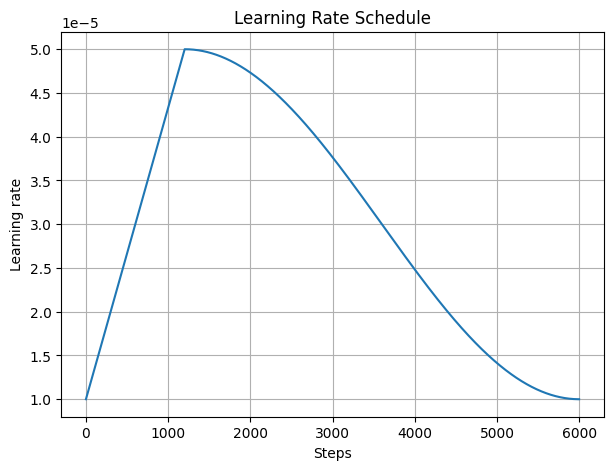

In [47]:
plot_and_save_learning_rate(ift_alpaca_training_results, filepath=directory_path + "learning_rate.png")

## Scratch Pad